In [1]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
import fiona
import pandas as pd
import geopandas as gpd
import rasterio as rio
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
# Source data, SRTM & GLIHT
srtm_source = os.path.join('/Users/arbailey/natcap/idb/data/source/srtm/nasa','SRTM30m_Andros.vrt')
glihtdtm_source = os.path.join('/Users/arbailey/natcap/idb/data/source/gliht/Andros_May2015/lidar/geotiff/Andros_May2015_DTM','Andros_May2015_DTM.vrt')
glihtchm_source = os.path.join('/Users/arbailey/natcap/idb/data/source/gliht/Andros_May2015/lidar/geotiff/Andros_May2015_CHM','Andros_May2015_CHM.vrt' )
# Working directory
work_dir = '/Users/arbailey/natcap/idb/data/work/andros_mangrovehgt'
os.chdir(work_dir)

In [3]:
# GLiHT Point layer with SRTM and Max Height attributes already assigned
gliht_srtm_hmax95_lyr = 'glihtchm_srtm_hmax95'

# Directories and data of mangrove layers to be sampled
mangroves_dir = '/Users/arbailey/natcap/idb/data/work/mangroves'
mangroves_gpkg = os.path.join(mangroves_dir, 'mangroves_andros.gpkg')
## Layers
# # Simard - Mangrove Height
# mangrovehgt_tif = 'Mangrove_hmax95_andros.tif'
# mangrovehgt_source = os.path.join(mangroves_dir, mangrovehgt_tif)
# Giri - Global Mangrove Forest
gmf_lyr = 'gmf_andros'
# Spalding - World Atlas of Mangroves
wam_lyr = 'wam2010_andros_droppedfields'
# Bunting - Global Mangrove Watch
gmw19962016_lyr = 'gmw_1996_2016_andros'
gmw2015_lyr = 'GMW_2015_v2_andros'
# TNC Landsat Mangroves
tnclandsat_lyr = 'mar_mangroves_2006'
# NatCap / TNC mangroves minus coppice and DBLE
ncmangwet_lyr = 'and_mar_wetlandmangrove_NATCAP' #'and_mar_wetlandmangrove_NATCAP_sp'

# Output Geopackage
out_gpkg = os.path.join(work_dir, 'gliht_srtm.gpkg')

In [4]:
%%time
# Load mangrove polygon layers in GeoDataFrames
gmf = gpd.read_file(mangroves_gpkg, layer=gmf_lyr) # Giri, Global Mangrove Forests
wam = gpd.read_file(mangroves_gpkg, layer=wam_lyr) # Spalding, World Atlas of Mangroves
gmw19962016 = gpd.read_file(mangroves_gpkg, layer=gmw19962016_lyr)  # Bunting, Global Mangrove Watch - all years
gmw2015 = gpd.read_file(mangroves_gpkg, layer=gmw2015_lyr) # Bunting, Global Mangrove Watch 2015
tnclandsat = gpd.read_file(mangroves_gpkg, layer=tnclandsat_lyr) # TNC Landsat (2002) Mangrove Layer
ncmangwet = gpd.read_file(mangroves_gpkg, layer=ncmangwet_lyr) # TNC/NatCap Mangrove/wetlands layer 

CPU times: user 24 s, sys: 1.4 s, total: 25.4 s
Wall time: 26.1 s


In [5]:
%%time
# TNC Landsat Mangroves
# Modify/Update Attributes
print(tnclandsat.head)
tnclandsat_att = 'tnclandsat'
tnclandsat[tnclandsat_att] = np.where(tnclandsat['grid_code']>=19, 1, 2)  # dense = 1, sparse = 2
tnclandsat = tnclandsat[[tnclandsat_att,'geometry']] # include only ncmangwet and geometry columns
tnclandsat

<bound method NDFrame.head of         area  perimeter  and_ply_bl  and_ply__1  grid_code            target  \
0      0.009       0.66         579         578         20  Sparse Mangroves   
1      0.015       0.84         602         601         20  Sparse Mangroves   
2      0.009       0.54         658         657         20  Sparse Mangroves   
3      0.008       0.54        1126        1125         20  Sparse Mangroves   
4      0.006       0.42        1131        1130         20  Sparse Mangroves   
...      ...        ...         ...         ...        ...               ...   
26454  0.013       0.66      101916      101915         20  Sparse Mangroves   
26455  0.008       0.54      102001      102000         20  Sparse Mangroves   
26456  0.009       0.60      102013      102012         20  Sparse Mangroves   
26457  0.004       0.36      102064      102063         20  Sparse Mangroves   
26458  0.006       0.36      102087      102086         20  Sparse Mangroves   

       ac

,tnclandsat,geometry
0,1,"MULTIPOLYGON (((181242.000 2808898.750, 181272..."
1,1,"MULTIPOLYGON (((181452.000 2808568.750, 181422..."
2,1,"MULTIPOLYGON (((181542.000 2808268.750, 181422..."
3,1,"MULTIPOLYGON (((183912.000 2805538.750, 183942..."
4,1,"MULTIPOLYGON (((184092.000 2805388.750, 184062..."
...,...,...
26454,1,"MULTIPOLYGON (((216612.000 2607658.750, 216612..."
26455,1,"MULTIPOLYGON (((216852.000 2607328.750, 216822..."
26456,1,"MULTIPOLYGON (((217092.000 2607298.750, 217092..."
26457,1,"MULTIPOLYGON (((216852.000 2607088.750, 216822..."


In [6]:
%%time
# NatCap/TNC Mangroves & Wetlands layer
# Modify/Update Attributes
print(ncmangwet.columns)
print(ncmangwet.head)
ncmangwet_att = 'ncmangwet'
ncmangwet[ncmangwet_att] = 1 # all polygons in the layer are mangroves, so set ncmangwet = 1
ncmangwet = ncmangwet[[ncmangwet_att,'geometry']] # include only ncmangwet and geometry columns
ncmangwet

Index(['Id', 'geometry'], dtype='object')
<bound method NDFrame.head of    Id                                           geometry
0   0  POLYGON ((186615.748 2740172.278, 186615.748 2...
1   0  POLYGON ((209840.748 2739952.278, 209840.748 2...
2   0  POLYGON ((176025.748 2791307.278, 176025.748 2...
3   0  POLYGON ((188130.748 2783822.278, 188130.748 2...
4   0  POLYGON ((218712.000 2612488.750, 218832.000 2...
5   0  POLYGON ((229615.748 2668272.278, 229610.748 2...
6   0  POLYGON ((226565.748 2674922.278, 226565.748 2...
7   0  POLYGON ((225345.748 2702757.278, 225342.000 2...
8   0  POLYGON ((182800.748 2760297.278, 182790.748 2...>
CPU times: user 18.7 s, sys: 648 ms, total: 19.3 s
Wall time: 19.3 s


,ncmangwet,geometry
0,1,"POLYGON ((186615.748 2740172.278, 186615.748 2..."
1,1,"POLYGON ((209840.748 2739952.278, 209840.748 2..."
2,1,"POLYGON ((176025.748 2791307.278, 176025.748 2..."
3,1,"POLYGON ((188130.748 2783822.278, 188130.748 2..."
4,1,"POLYGON ((218712.000 2612488.750, 218832.000 2..."
5,1,"POLYGON ((229615.748 2668272.278, 229610.748 2..."
6,1,"POLYGON ((226565.748 2674922.278, 226565.748 2..."
7,1,"POLYGON ((225345.748 2702757.278, 225342.000 2..."
8,1,"POLYGON ((182800.748 2760297.278, 182790.748 2..."


In [7]:
# Import the previously joined point file layer into GeoDataFrame (includes wam and gmf)
%time gliht_srtm_hmax95_mangroves3 = gpd.read_file(out_gpkg, layer='glihtchm_srtm_hmax95_mangroves3')
gliht_srtm_hmax95_mangroves3

CPU times: user 31min 14s, sys: 47min 49s, total: 1h 19min 4s
Wall time: 1h 47min 58s


,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry
0,0.0,788785.5,2787858.5,0,21282071,NaN,14210037,1,NaN,NaN,NaN,NaN,POINT (-78.13478 25.17915)
1,0.0,788781.5,2787857.5,0,21282071,NaN,14210036,2,NaN,NaN,NaN,NaN,POINT (-78.13482 25.17914)
2,0.0,788784.5,2787857.5,0,21282071,NaN,14210037,3,NaN,NaN,NaN,NaN,POINT (-78.13479 25.17914)
3,0.0,788776.5,2787856.5,0,21282070,NaN,14210036,4,NaN,NaN,NaN,NaN,POINT (-78.13487 25.17913)
4,0.0,788778.5,2787856.5,0,21282071,NaN,14210036,5,NaN,NaN,NaN,NaN,POINT (-78.13485 25.17913)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58150139,0.0,802646.5,2691223.5,0,43944037,NaN,44267460,58146867,NaN,NaN,NaN,NaN,POINT (-78.01828 24.30487)
58150140,0.0,802641.5,2691222.5,0,43951238,NaN,44267460,58146868,NaN,NaN,NaN,NaN,POINT (-78.01833 24.30486)
58150141,0.0,802644.5,2691221.5,0,43951238,NaN,44267460,58146869,NaN,NaN,NaN,NaN,POINT (-78.01830 24.30485)
58150142,0.0,802646.5,2691220.5,0,43951238,NaN,44267460,58146870,NaN,NaN,NaN,NaN,POINT (-78.01828 24.30484)


In [8]:
pt_crs = gliht_srtm_hmax95_mangroves3.crs
pt_crs

{'init': 'epsg:4326'}

In [9]:
# Reproject TNC Landsat Data to same CRS as source point data (EPSG 4326)
%time tnclandsat_4326 = tnclandsat.to_crs(pt_crs)
tnclandsat_4326

CPU times: user 5.98 s, sys: 580 ms, total: 6.56 s
Wall time: 7.99 s


,tnclandsat,geometry
0,1,"MULTIPOLYGON (((-78.16718 25.36281, -78.16688 ..."
1,1,"MULTIPOLYGON (((-78.16502 25.35988, -78.16532 ..."
2,1,"MULTIPOLYGON (((-78.16406 25.35720, -78.16525 ..."
3,1,"MULTIPOLYGON (((-78.13990 25.33308, -78.13960 ..."
4,1,"MULTIPOLYGON (((-78.13808 25.33177, -78.13838 ..."
...,...,...
26454,1,"MULTIPOLYGON (((-77.77599 23.55458, -77.77597 ..."
26455,1,"MULTIPOLYGON (((-77.77358 23.55165, -77.77387 ..."
26456,1,"MULTIPOLYGON (((-77.77122 23.55142, -77.77122 ..."
26457,1,"MULTIPOLYGON (((-77.77353 23.54948, -77.77382 ..."


In [10]:
# Reproject NatCap/TNC mangroves/wetlands layer to same CRS as source point data (EPSG 4326)
%time ncmangwet_4326 = ncmangwet.to_crs(pt_crs)
ncmangwet_4326

CPU times: user 5min 59s, sys: 1min 16s, total: 7min 16s
Wall time: 8min 31s


,ncmangwet,geometry
0,1,"POLYGON ((-78.09822 24.74420, -78.09822 24.744..."
1,1,"POLYGON ((-77.86880 24.74678, -77.86880 24.746..."
2,1,"POLYGON ((-78.21476 25.20308, -78.21476 25.203..."
3,1,"POLYGON ((-78.09308 25.13814, -78.09308 25.138..."
4,1,"POLYGON ((-77.75635 23.59852, -77.75517 23.598..."
5,1,"POLYGON ((-77.65985 24.10370, -77.65990 24.103..."
6,1,"POLYGON ((-77.69109 24.16317, -77.69108 24.163..."
7,1,"POLYGON ((-77.70841 24.41409, -77.70844 24.414..."
8,1,"POLYGON ((-78.14047 24.92489, -78.14057 24.924..."


In [11]:
# %%time
# # Join attributes of NatCap/TNC mangrove/wetland polygons to master point layer
# join5 = gpd.sjoin(gliht_srtm_hmax95_mangroves3, ncmangwet_4326, how="left")
# join5 = join5.drop(columns='index_right')
# join5
# ----- This ran for 58 hours and never completed.

In [12]:
# # export to Geopackage
# %time join5.to_file("gliht_srtm.gpkg", layer='glihtchm_srtm_hmax95_mangroves4', driver="GPKG")

In [13]:
# # # export v3 to GeoJSON 
# %time gliht_srtm_hmax95_mangroves3.to_file(filename='glihtchm_srtm_hmax95_mangroves3.geojson', driver="GeoJSON")

In [14]:
gliht_srtm_hmax95_mangroves3

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry
0,0.0,788785.5,2787858.5,0,21282071,NaN,14210037,1,NaN,NaN,NaN,NaN,POINT (-78.13478 25.17915)
1,0.0,788781.5,2787857.5,0,21282071,NaN,14210036,2,NaN,NaN,NaN,NaN,POINT (-78.13482 25.17914)
2,0.0,788784.5,2787857.5,0,21282071,NaN,14210037,3,NaN,NaN,NaN,NaN,POINT (-78.13479 25.17914)
3,0.0,788776.5,2787856.5,0,21282070,NaN,14210036,4,NaN,NaN,NaN,NaN,POINT (-78.13487 25.17913)
4,0.0,788778.5,2787856.5,0,21282071,NaN,14210036,5,NaN,NaN,NaN,NaN,POINT (-78.13485 25.17913)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58150139,0.0,802646.5,2691223.5,0,43944037,NaN,44267460,58146867,NaN,NaN,NaN,NaN,POINT (-78.01828 24.30487)
58150140,0.0,802641.5,2691222.5,0,43951238,NaN,44267460,58146868,NaN,NaN,NaN,NaN,POINT (-78.01833 24.30486)
58150141,0.0,802644.5,2691221.5,0,43951238,NaN,44267460,58146869,NaN,NaN,NaN,NaN,POINT (-78.01830 24.30485)
58150142,0.0,802646.5,2691220.5,0,43951238,NaN,44267460,58146870,NaN,NaN,NaN,NaN,POINT (-78.01828 24.30484)


In [15]:
fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r'}

In [16]:
fiona.__version__

'1.8.6'

In [17]:
gpd.__version__

'0.6.1'

In [18]:
# Create Variable for master points data  - for easier transferablity
pts_all = gliht_srtm_hmax95_mangroves3

In [19]:
# Subset to include on CHM height > 0 and Max Height > 0
pts_gt0_hmax = pts_all[(pts_all['z_m'] > 0) & (pts_all['hmax95'] > 0)]
pts_gt0_hmax

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry
40952733,0.56,802948.5,2715713.5,8,38219272,8.485,36677637,40952734,NaN,NaN,NaN,NaN,POINT (-78.01010 24.52570)
40957062,0.42,802938.5,2715708.5,5,38226472,8.485,36677637,40957063,NaN,NaN,NaN,NaN,POINT (-78.01020 24.52565)
40959655,0.40,802943.5,2715705.5,5,38226472,8.485,36677637,40959656,NaN,NaN,NaN,NaN,POINT (-78.01015 24.52562)
40972661,0.44,802936.5,2715690.5,5,38226472,8.485,36677637,40972662,NaN,NaN,NaN,NaN,POINT (-78.01022 24.52549)
40973524,0.41,802935.5,2715689.5,5,38226472,8.485,36677637,40973525,NaN,NaN,NaN,NaN,POINT (-78.01023 24.52548)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57668258,0.47,803949.5,2694149.5,2,43267192,5.091,43360185,57664986,1.0,NaN,NaN,1.0,POINT (-78.00483 24.33101)
57668628,0.94,803911.5,2694148.5,5,43267190,8.485,43360184,57665356,1.0,NaN,NaN,1.0,POINT (-78.00521 24.33100)
57668629,0.97,803912.5,2694148.5,5,43267190,8.485,43360184,57665357,1.0,NaN,NaN,1.0,POINT (-78.00520 24.33100)
57668652,0.27,803935.5,2694148.5,3,43267191,5.091,43360185,57665380,1.0,NaN,NaN,1.0,POINT (-78.00497 24.33100)


In [20]:
pts_gt0_hmax.describe()

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat
count,9.490960e+05,949096.000000,9.490960e+05,949096.000000,9.490960e+05,949096.000000,9.490960e+05,9.490960e+05,907609.0,731.0,765515.0,434217.0
mean,1.583601e+00,797098.344994,2.700176e+06,5.039006,4.182648e+07,8.501106,4.145247e+07,5.389936e+07,1.0,1.0,1.0,1.0
std,9.978933e-01,3370.083513,3.969259e+03,1.886727,9.267010e+05,3.026943,1.228882e+06,3.253263e+06,0.0,0.0,0.0,0.0
min,3.552714e-15,793049.500000,2.694148e+06,-5.000000,3.821927e+07,0.848500,3.667764e+07,4.095273e+07,1.0,1.0,1.0,1.0
25%,8.900000e-01,793599.500000,2.697794e+06,4.000000,4.147404e+07,6.788000,4.098374e+07,5.261986e+07,1.0,1.0,1.0,1.0
50%,1.380000e+00,797719.500000,2.699160e+06,5.000000,4.204266e+07,8.485000,4.174676e+07,5.488682e+07,1.0,1.0,1.0,1.0
75%,2.090000e+00,799593.500000,2.701730e+06,6.000000,4.238848e+07,10.182000,4.219342e+07,5.595689e+07,1.0,1.0,1.0,1.0
max,1.115000e+01,806787.500000,2.715714e+06,12.000000,4.326719e+07,13.576000,4.336018e+07,5.766538e+07,1.0,1.0,1.0,1.0


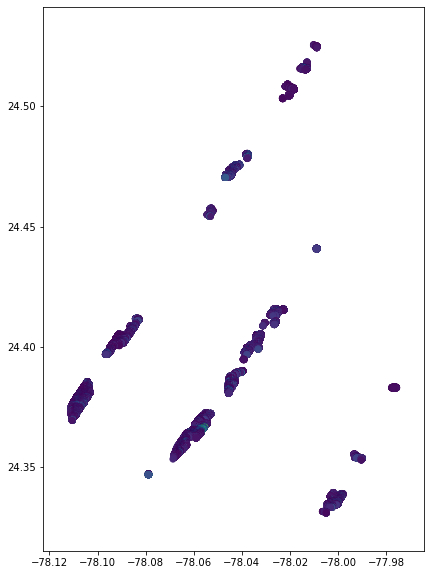

In [21]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
pts_gt0_hmax.plot(column='gmf', ax=ax)
pts_gt0_hmax.plot(column='z_m', ax=ax)
plt.show()

## Compare GLiHT heights to Simard Max Height (extent is same as GMF data)

In [22]:
# Multiple stats on a single column (could be many columns) --> renamed
# Makes the grouped columns into multi-column index
groupedHmax_gliht = pts_gt0_hmax.groupby(
    ['hmax95_id','hmax95']
).agg(
    max_z = ('z_m', 'max'),
    min_z = ('z_m', 'min'),
    mean_z = ('z_m', 'mean'),
    median_z = ('z_m', 'median'),
    var_z = ('z_m', 'var'),
    skew_z = ('z_m', 'skew'),
    count_z = ('z_m', 'count'),
) 
groupedHmax_gliht.reset_index(inplace=True)  # Reset index to make grouped columns into regular columns
groupedHmax_gliht

,hmax95_id,hmax95,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,36677637,8.485,0.97,4.000000e-01,0.533333,0.43,0.049187,2.111162,6
1,36699244,6.788,1.10,1.200000e-01,0.447949,0.42,0.049548,1.062570,39
2,36699245,6.788,1.32,9.000000e-02,0.430857,0.33,0.110037,1.494465,35
3,36706446,3.394,1.37,1.421085e-14,0.525600,0.43,0.110334,0.752435,25
4,36713647,3.394,1.23,2.000000e-01,0.755294,0.79,0.102126,-0.365430,17
...,...,...,...,...,...,...,...,...,...
2359,43352982,5.091,3.36,3.100000e-01,1.534966,1.27,0.781882,0.627970,149
2360,43352983,10.182,2.00,1.000000e-01,0.940426,0.89,0.234565,0.389676,47
2361,43352984,5.091,2.96,2.000000e-01,1.100000,0.80,0.519807,0.672721,55
2362,43360184,8.485,1.84,3.300000e-01,1.088437,1.06,0.133149,0.232242,32


In [23]:
groupedHmax_gliht.describe()

,hmax95_id,hmax95,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
count,2.364000e+03,2364.000000,2364.000000,2.364000e+03,2364.000000,2364.000000,2351.000000,2336.000000,2364.000000
mean,4.143253e+07,8.180631,3.401294,2.077200e-01,1.391265,1.313280,0.476159,0.630806,401.478849
std,1.343389e+06,3.128384,1.413514,2.368439e-01,0.613786,0.616591,0.484939,0.578781,278.928325
min,3.667764e+07,0.848500,0.300000,3.552714e-15,0.280000,0.280000,0.000000,-1.964019,1.000000
25%,4.094751e+07,6.788000,2.600000,8.000000e-02,1.016375,0.938750,0.234558,0.268617,118.750000
50%,4.171797e+07,8.485000,3.310000,1.300000e-01,1.279848,1.190000,0.389122,0.576660,410.000000
75%,4.222221e+07,10.182000,3.980000,2.500000e-01,1.630786,1.540000,0.596325,0.951809,661.000000
max,4.336018e+07,13.576000,11.150000,4.360000e+00,6.064164,5.995000,8.716372,3.963125,877.000000


In [24]:
def linear_regress(df, x_att, y_att, fi=True):
    linear_regressor = LinearRegression(fit_intercept=fi)  # create object for the class
    X = df[x_att].values.reshape(-1, 1)
    Y = df[y_att].values.reshape(-1, 1)
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions

    plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='orange')
    plt.xlabel(x_att)
    plt.ylabel(y_att)
    plt.show()

    r_sq = linear_regressor.score(X, Y)
    print("R squared:", r_sq)
    intercept = linear_regressor.intercept_
    print("intercept:", intercept)
    slope = linear_regressor.coef_
    print("slope:", slope)
    rmse = np.sqrt(mean_squared_error(y_true=Y, y_pred=Y_pred))
    print("RMSE:", rmse)

Some graphing examples and inspiration:  
https://python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/  
https://python-graph-gallery.com/82-marginal-plot-with-seaborn/  
https://python-graph-gallery.com/2d-density-plot/  
https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/  
https://seaborn.pydata.org/tutorial/regression.html#regression-tutorial  
https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f  
https://www.earthdatascience.org/courses/earth-analytics-python/lidar-remote-sensing-uncertainty/compare-lidar-and-measured-tree-height-regression/

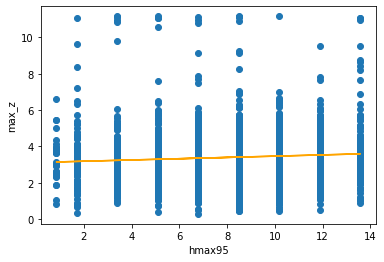

R squared: 0.00597897970925132
intercept: [3.11548251]
slope: [[0.03493764]]
RMSE: 1.4089834041429226


In [25]:
linear_regress(groupedHmax_gliht, 'hmax95', 'max_z', True)

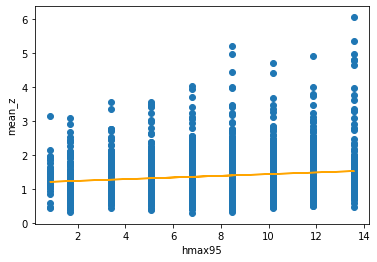

R squared: 0.01583999713823736
intercept: [1.18926042]
slope: [[0.02469305]]
RMSE: 0.6087768711710054


In [26]:
linear_regress(groupedHmax_gliht, 'hmax95', 'mean_z', True)

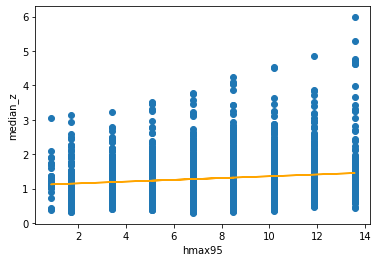

R squared: 0.017208175066731557
intercept: [1.10177036]
slope: [[0.02585499]]
RMSE: 0.6111330517251253


In [27]:
linear_regress(groupedHmax_gliht, 'hmax95', 'median_z', True)

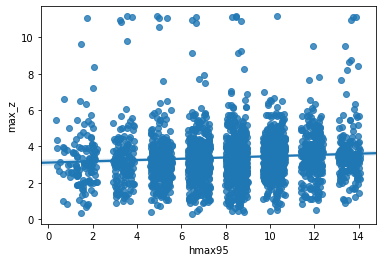

In [28]:
# Scatter plot with jitter
sns.regplot(x="hmax95", y="max_z", data=groupedHmax_gliht,  x_jitter=.5);

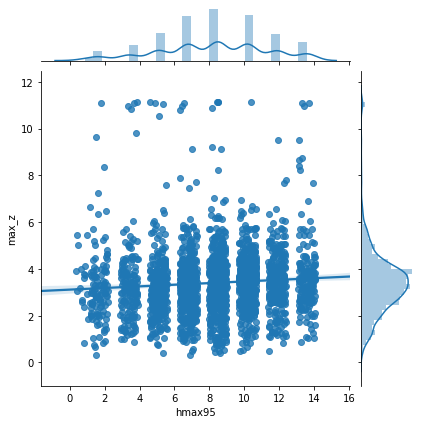

In [29]:
# Scatter plot, regression, and kernel density fits
sns.jointplot(x="hmax95", y="max_z", data=groupedHmax_gliht, kind="reg", x_jitter=.5)

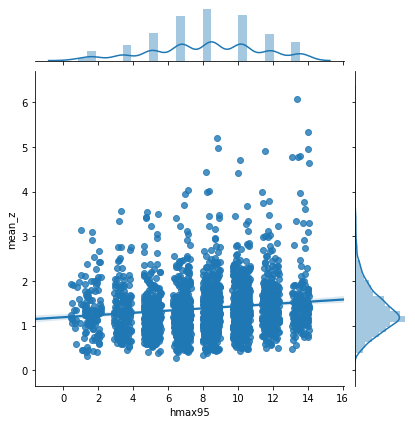

In [30]:
# Scatter plot, regression, and kernel density fits
sns.jointplot(x="hmax95", y="mean_z", data=groupedHmax_gliht, kind="reg", x_jitter=.5)

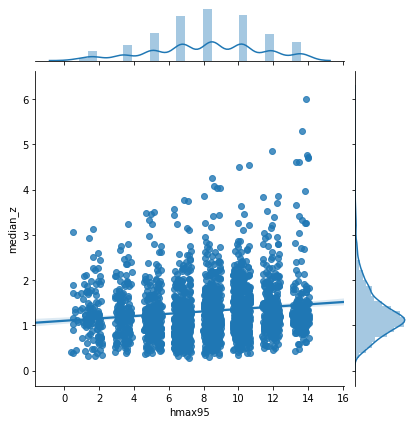

In [31]:
# Scatter plot, regression, and kernel density fits
sns.jointplot(x="hmax95", y="median_z", data=groupedHmax_gliht, kind="reg", x_jitter=.5)

Text(0.0, 1.0, '2D density graph')

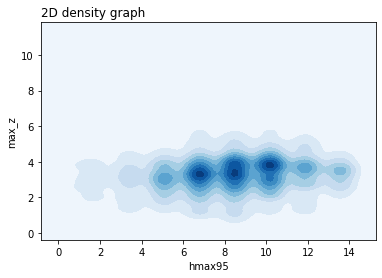

In [32]:
# 2D density graph
sns.kdeplot(groupedHmax_gliht['hmax95'],groupedHmax_gliht['max_z'], cmap="Blues", shade=True)
plt.title('2D density graph', loc='left')

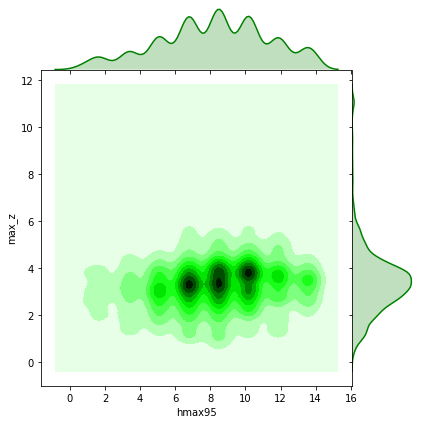

In [33]:
sns.jointplot(x="hmax95", y="max_z", data=groupedHmax_gliht, kind="kde", space=0, color="green")

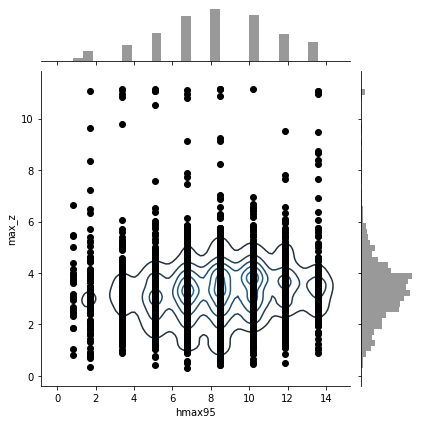

In [34]:
g = (sns.jointplot(x="hmax95", y="max_z", data=groupedHmax_gliht, color="black")
      .plot_joint(sns.kdeplot, zorder=0, n_levels=6))

Text(0.0, 1, 'Simard max height vs GLiHT max height')

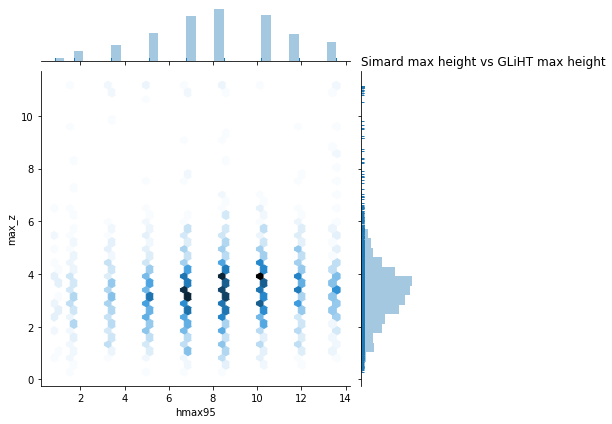

In [35]:
sns.jointplot(x=groupedHmax_gliht['hmax95'], y=groupedHmax_gliht['max_z'], 
              kind='hex', height=6,
              marginal_kws=dict(bins=30, rug=True))
plt.title('Simard max height vs GLiHT max height', loc='left')

## Compare GLiHT to SRTM for Global Mangrove Forest (GMF) data

In [36]:
# Subset to include on CHM height > 0 and GMF > 0
pts_gt0_gmf= pts_all[(pts_all['z_m'] > 0) & (pts_all['gmf'] > 0)]
pts_gt0_gmf

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry
40956198,0.54,802959.5,2715709.5,7,38226473,NaN,36677638,40956199,1.0,NaN,NaN,1.0,POINT (-78.00999 24.52566)
40956199,0.31,802971.5,2715709.5,7,38226473,NaN,36677638,40956200,1.0,NaN,NaN,1.0,POINT (-78.00987 24.52565)
40958790,0.70,802963.5,2715706.5,7,38226473,NaN,36677638,40958791,1.0,NaN,NaN,1.0,POINT (-78.00995 24.52563)
40961393,0.60,802973.5,2715703.5,6,38226474,NaN,36677638,40961394,1.0,NaN,NaN,1.0,POINT (-78.00986 24.52560)
40964002,1.28,802959.5,2715700.5,7,38226473,NaN,36677638,40964003,1.0,NaN,NaN,1.0,POINT (-78.01000 24.52558)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57670715,0.48,803953.5,2694143.5,2,43274393,NaN,43374588,57667443,1.0,NaN,NaN,1.0,POINT (-78.00479 24.33095)
57670719,0.98,803957.5,2694143.5,2,43274393,NaN,43374588,57667447,1.0,NaN,NaN,1.0,POINT (-78.00476 24.33095)
57670727,0.10,803965.5,2694143.5,2,43274393,NaN,43374588,57667455,1.0,NaN,NaN,1.0,POINT (-78.00468 24.33095)
57671066,1.29,803895.5,2694142.5,4,43274391,NaN,43374585,57667794,1.0,NaN,NaN,1.0,POINT (-78.00537 24.33095)


In [37]:
pts_gt0_gmf.describe()

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat
count,9.791010e+05,979101.000000,9.791010e+05,979101.000000,9.791010e+05,907609.000000,9.791010e+05,9.791010e+05,979101.0,633.0,786736.0,451898.0
mean,1.581893e+00,797192.044763,2.700249e+06,4.972104,4.180981e+07,8.487160,4.143040e+07,5.383699e+07,1.0,1.0,1.0,1.0
std,9.954536e-01,3401.909415,4.067978e+03,1.997306,9.494552e+05,3.012594,1.259047e+06,3.335147e+06,0.0,0.0,0.0,0.0
min,3.552714e-15,793067.500000,2.694142e+06,-5.000000,3.822647e+07,0.848500,3.667764e+07,4.095620e+07,1.0,1.0,1.0,1.0
25%,8.800000e-01,793609.500000,2.697804e+06,4.000000,4.145963e+07,6.788000,4.096214e+07,5.258604e+07,1.0,1.0,1.0,1.0
50%,1.380000e+00,797781.500000,2.699160e+06,5.000000,4.204266e+07,8.485000,4.174676e+07,5.488598e+07,1.0,1.0,1.0,1.0
75%,2.090000e+00,799634.500000,2.701756e+06,6.000000,4.238848e+07,10.182000,4.219342e+07,5.595029e+07,1.0,1.0,1.0,1.0
max,1.115000e+01,806776.500000,2.715710e+06,12.000000,4.327439e+07,13.576000,4.337459e+07,5.766780e+07,1.0,1.0,1.0,1.0


### Scatter Plot of SRTM vs. GLiHT canopy height -- all data points

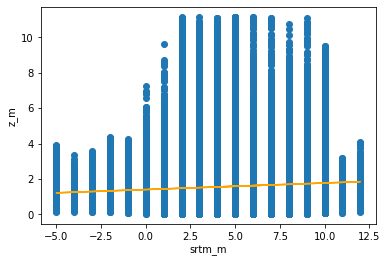

R squared: 0.005527223251264202
intercept: [1.39765914]
slope: [[0.03705356]]
RMSE: 0.992698240829192


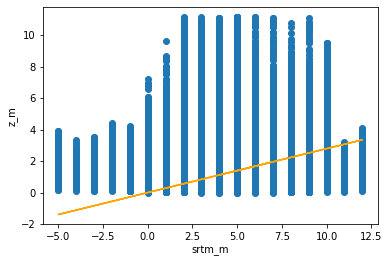

R squared: -0.2683781667159306
intercept: 0.0
slope: [[0.27909654]]
RMSE: 1.1211021400756527


In [38]:
linear_regress(pts_gt0_gmf, 'srtm_m', 'z_m', True)
linear_regress(pts_gt0_gmf, 'srtm_m', 'z_m', False) # define intercept as 0

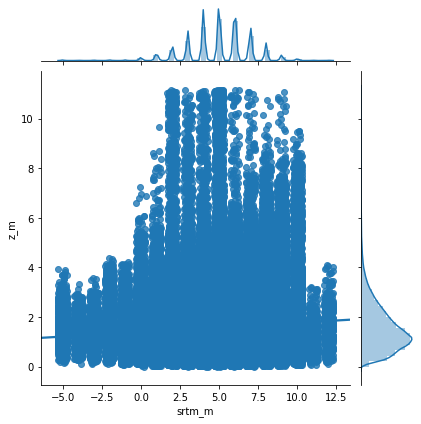

In [39]:
# Scatter plot, regression, and kernel density fits
sns.jointplot(x="srtm_m", y="z_m", data=pts_gt0_gmf, kind="reg", x_jitter=.3)

Text(0.0, 1, 'SRTM vs GLiHT Canopy height in GMF data')

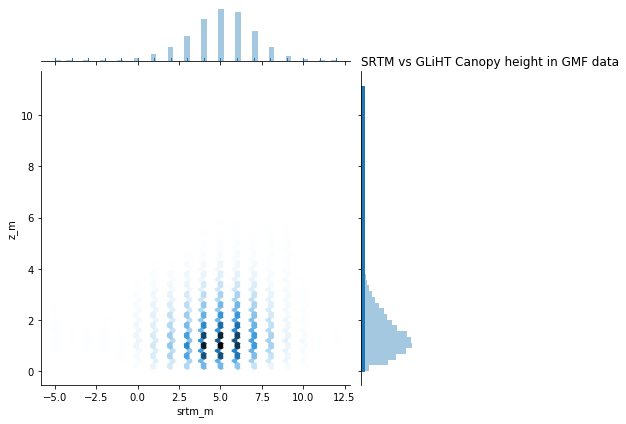

In [40]:
sns.jointplot(x=pts_gt0_gmf['srtm_m'], y=pts_gt0_gmf['z_m'], 
              kind='hex', height=6,
              marginal_kws=dict(rug=True))
plt.title('SRTM vs GLiHT Canopy height in GMF data', loc='left')

### Scatter Plot of SRTM vs. GLiHT canopy height -- grouped by SRTM ID and height

In [41]:
# Multiple stats on a single column (could be many columns) --> renamed
# Makes the grouped columns into multi-column index
groupedSRTM_gliht_gmf = pts_gt0_gmf.groupby(
    ['srtm_id','srtm_m']
).agg(
    max_z = ('z_m', 'max'),
    min_z = ('z_m', 'min'),
    mean_z = ('z_m', 'mean'),
    median_z = ('z_m', 'median'),
    var_z = ('z_m', 'var'),
    skew_z = ('z_m', 'skew'),
    count_z = ('z_m', 'count'),
) 
groupedSRTM_gliht_gmf.reset_index(inplace=True)  # Reset index to make grouped columns into regular columns
groupedSRTM_gliht_gmf

,srtm_id,srtm_m,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,38226473,7,1.28,0.15,0.592000,0.560,0.101008,0.259087,25
1,38226474,6,0.95,0.25,0.553333,0.575,0.057467,0.621611,6
2,38233674,6,0.50,0.50,0.500000,0.500,NaN,NaN,1
3,38233675,6,0.29,0.29,0.290000,0.290,NaN,NaN,1
4,38240879,4,1.32,0.09,0.426000,0.360,0.102335,1.601999,30
...,...,...,...,...,...,...,...,...,...
2969,43267192,2,2.40,0.12,1.163102,1.140,0.352776,0.236896,187
2970,43274390,1,1.41,1.41,1.410000,1.410,NaN,NaN,1
2971,43274391,4,1.46,0.43,1.120000,1.295,0.217667,-1.828031,4
2972,43274392,3,1.74,0.20,0.757857,0.725,0.195187,1.186725,14


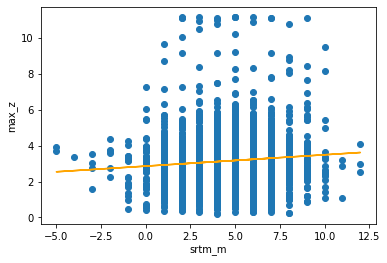

R squared: 0.008121812868135181
intercept: [2.85902768]
slope: [[0.06309013]]
RMSE: 1.4416676856279735


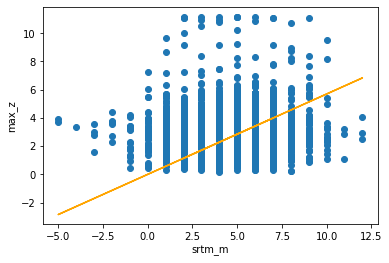

R squared: -0.6145619667192279
intercept: 0.0
slope: [[0.56950339]]
RMSE: 1.8393456652587101


In [42]:
linear_regress(groupedSRTM_gliht_gmf, 'srtm_m', 'max_z', True)
linear_regress(groupedSRTM_gliht_gmf, 'srtm_m', 'max_z', False) # define intercept as 0

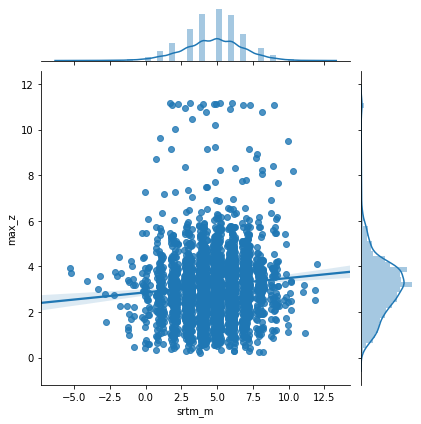

In [43]:
# Scatter plot, regression, and kernel density fits
sns.jointplot(x="srtm_m", y="max_z", data=groupedSRTM_gliht_gmf, kind="reg", x_jitter=.3)

Text(0.0, 1, 'SRTM vs Max GLiHT Canopy height in GMF data')

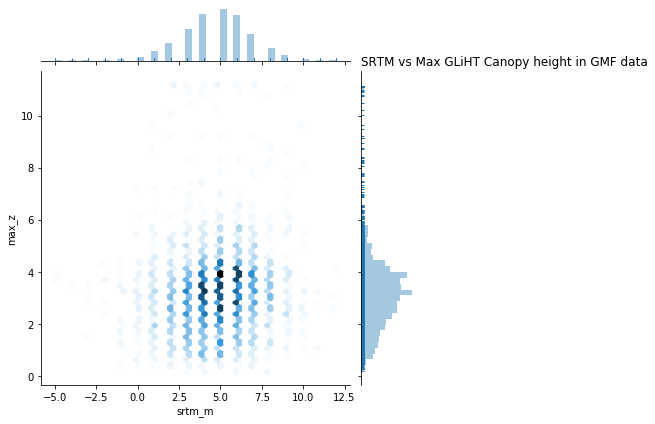

In [44]:
sns.jointplot(x=groupedSRTM_gliht_gmf['srtm_m'], y=groupedSRTM_gliht_gmf['max_z'], 
              kind='hex', height=6,
              marginal_kws=dict(rug=True))
plt.title('SRTM vs Max GLiHT Canopy height in GMF data', loc='left')

## Compare GLiHT to SRTM for World Atlas of Mangroves (WAM) data

In [45]:
# Subset to include on CHM height > 0 and WAM > 0
pts_gt0_wam= pts_all[(pts_all['z_m'] > 0) & (pts_all['wam'] > 0)]
pts_gt0_wam

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry
1148154,1.44,791859.5,2782602.5,1,22527949,NaN,15859179,1148155,NaN,1.0,1.0,NaN,POINT (-78.10543 25.13115)
1148157,0.38,791862.5,2782602.5,0,22527950,NaN,15859179,1148158,NaN,1.0,1.0,NaN,POINT (-78.10540 25.13115)
1148554,1.69,791859.5,2782601.5,1,22527949,NaN,15859179,1148555,NaN,1.0,1.0,NaN,POINT (-78.10543 25.13114)
1148555,0.29,791860.5,2782601.5,1,22527949,NaN,15859179,1148556,NaN,1.0,1.0,NaN,POINT (-78.10542 25.13114)
1148556,0.31,791861.5,2782601.5,0,22527950,NaN,15859179,1148557,NaN,1.0,1.0,NaN,POINT (-78.10541 25.13114)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57103031,0.48,796885.5,2695926.5,7,42820481,NaN,42769437,57103032,NaN,1.0,NaN,1.0,POINT (-78.07400 24.34839)
57103598,0.31,796487.5,2695923.5,1,42820466,NaN,42769422,57103599,NaN,1.0,NaN,1.0,POINT (-78.07792 24.34844)
57103599,0.39,796503.5,2695923.5,3,42820467,NaN,42769423,57103600,NaN,1.0,NaN,1.0,POINT (-78.07776 24.34844)
57104896,0.24,796470.5,2695916.5,1,42820466,NaN,42769422,57104897,NaN,1.0,NaN,1.0,POINT (-78.07809 24.34838)


### WAM vs SRTM - all data points

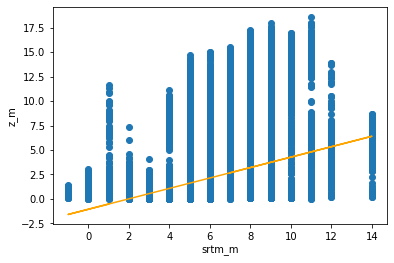

R squared: 0.1949110776450549
intercept: [-1.06734579]
slope: [[0.53353836]]
RMSE: 2.635489364484202


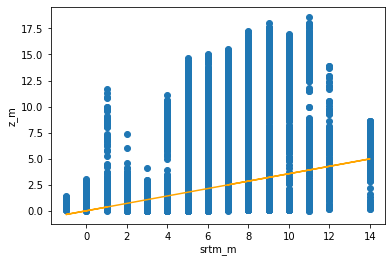

R squared: 0.1677265099474464
intercept: 0.0
slope: [[0.35597445]]
RMSE: 2.6796148333434258


Text(0.0, 1, 'SRTM vs GLiHT Canopy height in WAM data')

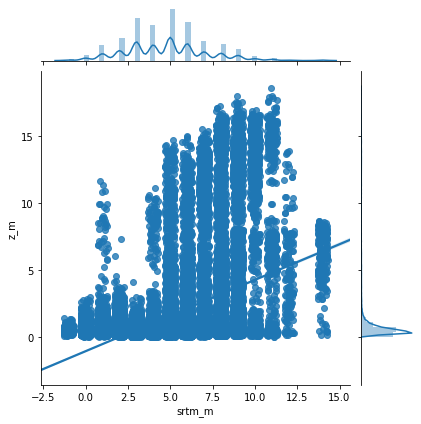

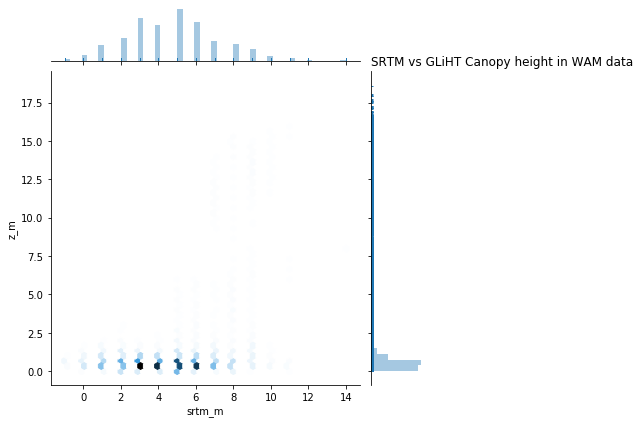

In [46]:
linear_regress(pts_gt0_wam, 'srtm_m', 'z_m', True)
linear_regress(pts_gt0_wam, 'srtm_m', 'z_m', False) # define intercept as 0
# Scatter plot with dither, regression, and kernel density fits
sns.jointplot(x="srtm_m", y="z_m", data=pts_gt0_wam, kind="reg", x_jitter=.3)
# Hex bin plot with regression and histograms
sns.jointplot(x=pts_gt0_wam['srtm_m'], y=pts_gt0_wam['z_m'], 
              kind='hex', height=6,
              marginal_kws=dict(rug=True))
plt.title('SRTM vs GLiHT Canopy height in WAM data', loc='left')

### WAM vs SRTM -- grouped by SRTM ID and height

In [47]:
# Multiple stats on a single column (could be many columns) --> renamed
# Makes the grouped columns into multi-column index
groupedSRTM_gliht_wam = pts_gt0_wam.groupby(
    ['srtm_id','srtm_m']
).agg(
    max_z = ('z_m', 'max'),
    min_z = ('z_m', 'min'),
    mean_z = ('z_m', 'mean'),
    median_z = ('z_m', 'median'),
    var_z = ('z_m', 'var'),
    skew_z = ('z_m', 'skew'),
    count_z = ('z_m', 'count'),
) 
groupedSRTM_gliht_wam.reset_index(inplace=True)  # Reset index to make grouped columns into regular columns
groupedSRTM_gliht_wam

,srtm_id,srtm_m,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,22527949,1,2.81,0.18,1.205872,1.180,0.308350,0.445203,109
1,22527950,0,3.02,0.06,1.082857,0.990,0.396961,0.798327,182
2,22527951,2,1.22,0.17,0.587647,0.530,0.091757,0.562316,17
3,22535149,4,1.50,1.50,1.500000,1.500,NaN,NaN,1
4,22535150,2,4.54,0.09,1.345322,1.190,0.570579,1.047721,543
...,...,...,...,...,...,...,...,...,...
966,42813282,5,0.30,0.17,0.235000,0.235,0.008450,NaN,2
967,42820466,1,0.31,0.24,0.275000,0.275,0.002450,NaN,2
968,42820467,3,0.39,0.39,0.390000,0.390,NaN,NaN,1
969,42820481,7,0.48,0.48,0.480000,0.480,NaN,NaN,1


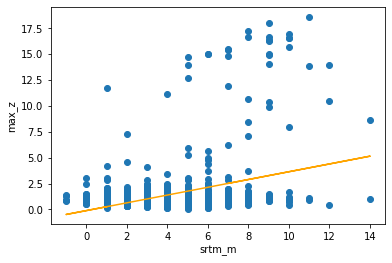

R squared: 0.103747200789853
intercept: [-0.11170713]
slope: [[0.37581611]]
RMSE: 2.390443502234948


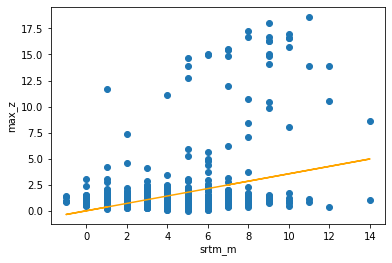

R squared: 0.10336961971471792
intercept: 0.0
slope: [[0.35544799]]
RMSE: 2.3909469824952714


Text(0.0, 1, 'SRTM vs GLiHT Canopy height in grouped WAM data')

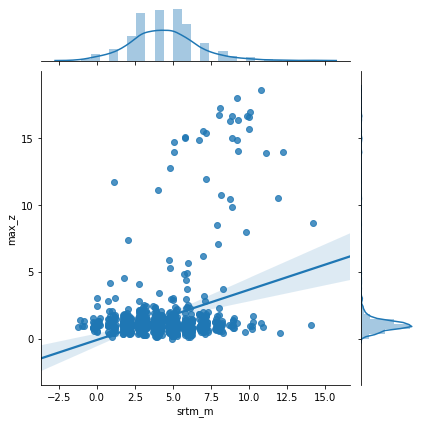

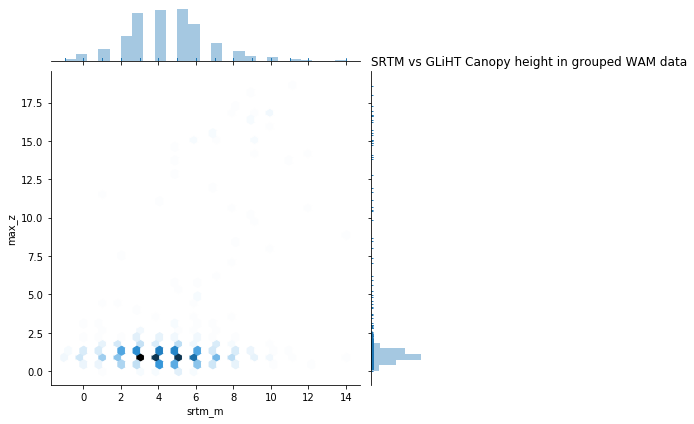

In [48]:
linear_regress(groupedSRTM_gliht_wam, 'srtm_m', 'max_z', True)
linear_regress(groupedSRTM_gliht_wam, 'srtm_m', 'max_z', False) # define intercept as 0
# Scatter plot with dither, regression, and kernel density fits
sns.jointplot(x="srtm_m", y="max_z", data=groupedSRTM_gliht_wam, kind="reg", x_jitter=.3)
# Hex bin plot with regression and histograms
sns.jointplot(x=groupedSRTM_gliht_wam['srtm_m'], y=groupedSRTM_gliht_wam['max_z'], 
              kind='hex', height=6,
              marginal_kws=dict(rug=True))
plt.title('SRTM vs GLiHT Canopy height in grouped WAM data', loc='left')

##  Global Mangrove Watch 2015 (GMW) -- Compare GLiHT to SRTM


In [49]:
# Subset to include on CHM height > 0 and GMW2015 > 0
pts_gt0_gmw2015= pts_all[(pts_all['z_m'] > 0) & (pts_all['gmw2015'] > 0)]
pts_gt0_gmw2015

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry
528814,1.14,790619.5,2784542.5,3,22067043,NaN,15247049,528815,NaN,NaN,1.0,1.0,POINT (-78.11730 25.14889)
528815,0.94,790620.5,2784542.5,3,22067043,NaN,15247049,528816,NaN,NaN,1.0,1.0,POINT (-78.11729 25.14889)
528816,0.71,790621.5,2784542.5,3,22067043,NaN,15247049,528817,NaN,NaN,1.0,1.0,POINT (-78.11728 25.14889)
528817,0.66,790622.5,2784542.5,3,22067043,NaN,15247049,528818,NaN,NaN,1.0,1.0,POINT (-78.11727 25.14889)
528818,1.03,790623.5,2784542.5,3,22067043,NaN,15247049,528819,NaN,NaN,1.0,1.0,POINT (-78.11726 25.14888)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57999722,0.83,803058.5,2691911.5,4,43785630,NaN,44058647,57996450,NaN,NaN,1.0,1.0,POINT (-78.01408 24.31099)
57999723,1.58,803059.5,2691911.5,4,43785630,NaN,44058647,57996451,NaN,NaN,1.0,1.0,POINT (-78.01407 24.31099)
58000111,1.25,803057.5,2691910.5,4,43785630,NaN,44058647,57996839,NaN,NaN,1.0,1.0,POINT (-78.01409 24.31098)
58000112,0.83,803058.5,2691910.5,4,43785630,NaN,44058647,57996840,NaN,NaN,1.0,1.0,POINT (-78.01408 24.31098)


### GMW 2015 vs SRTM - all data points

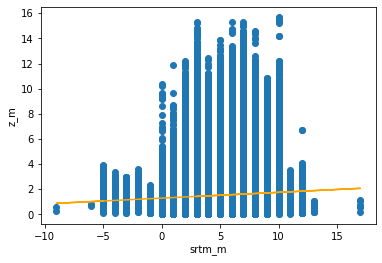

R squared: 0.008094011478427365
intercept: [1.29024892]
slope: [[0.04584722]]
RMSE: 1.00772877609229


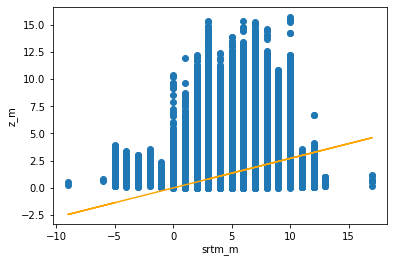

R squared: -0.21933564958599527
intercept: 0.0
slope: [[0.27123863]]
RMSE: 1.1173006199887656


Text(0.0, 1, 'SRTM vs GLiHT Canopy height in GMW 2015 data')

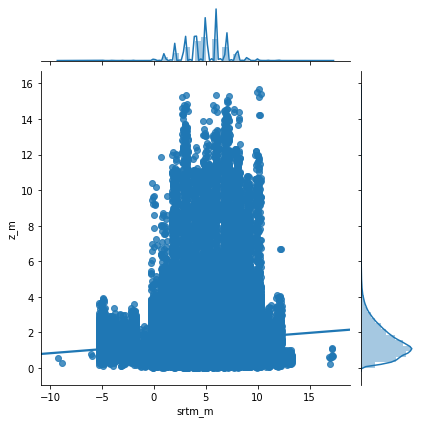

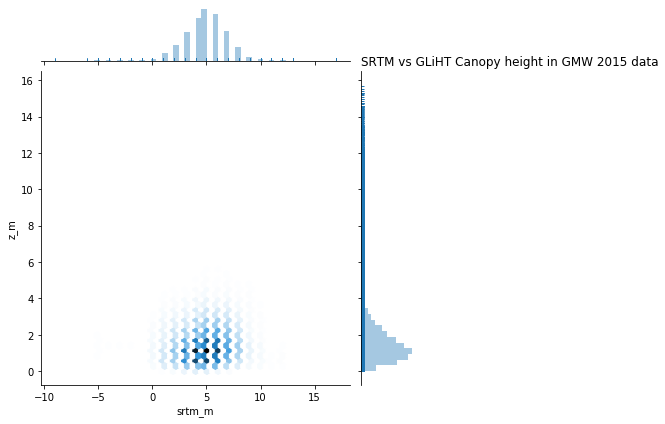

In [50]:
linear_regress(pts_gt0_gmw2015, 'srtm_m', 'z_m', True)
linear_regress(pts_gt0_gmw2015, 'srtm_m', 'z_m', False) # define intercept as 0
# Scatter plot with dither, regression, and kernel density fits
sns.jointplot(x="srtm_m", y="z_m", data=pts_gt0_gmw2015, kind="reg", x_jitter=.3)
# Hex bin plot with regression and histograms
sns.jointplot(x=pts_gt0_gmw2015['srtm_m'], y=pts_gt0_gmw2015['z_m'], 
              kind='hex', height=6,
              marginal_kws=dict(rug=True))
plt.title('SRTM vs GLiHT Canopy height in GMW 2015 data', loc='left')

### GMW 2015 vs SRTM -- grouped by SRTM ID and height

In [51]:
# Multiple stats on a single column (could be many columns) --> renamed
# Makes the grouped columns into multi-column index
groupedSRTM_gliht_gmw2015 = pts_gt0_gmw2015.groupby(
    ['srtm_id','srtm_m']
).agg(
    max_z = ('z_m', 'max'),
    min_z = ('z_m', 'min'),
    mean_z = ('z_m', 'mean'),
    median_z = ('z_m', 'median'),
    var_z = ('z_m', 'var'),
    skew_z = ('z_m', 'skew'),
    count_z = ('z_m', 'count'),
) 
groupedSRTM_gliht_gmw2015.reset_index(inplace=True)  # Reset index to make grouped columns into regular columns
groupedSRTM_gliht_gmw2015

,srtm_id,srtm_m,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,22067043,3,5.27,0.34,1.313671,1.225,0.441660,2.439983,158
1,22074244,3,11.30,0.24,3.057889,1.610,7.251687,1.231039,180
2,22081444,5,2.55,0.16,1.261026,1.195,0.307913,0.311364,78
3,22081445,5,3.26,0.27,1.790993,1.825,0.369937,-0.153040,554
4,22081446,3,2.60,0.32,1.543927,1.620,0.178798,-0.265527,219
...,...,...,...,...,...,...,...,...,...
3908,43267188,0,1.07,0.36,0.786667,0.930,0.141433,-1.465947,3
3909,43778431,-9,0.59,0.30,0.445000,0.445,0.042050,NaN,2
3910,43785630,4,1.58,0.83,1.122500,1.040,0.132225,0.662496,4
3911,43785631,-6,0.80,0.65,0.725000,0.725,0.011250,NaN,2


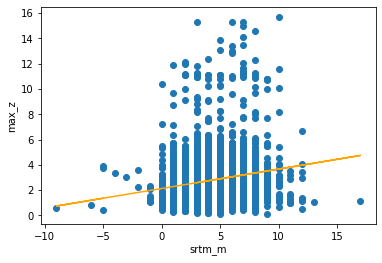

R squared: 0.03436235566317758
intercept: [2.12332944]
slope: [[0.15407481]]
RMSE: 1.7314266741939772


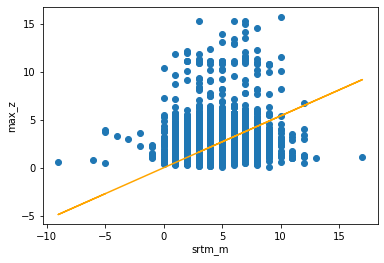

R squared: -0.22920115365592197
intercept: 0.0
slope: [[0.54012674]]
RMSE: 1.9534778425110508


Text(0.0, 1, 'SRTM vs GLiHT Canopy height in grouped GMW 2015 data')

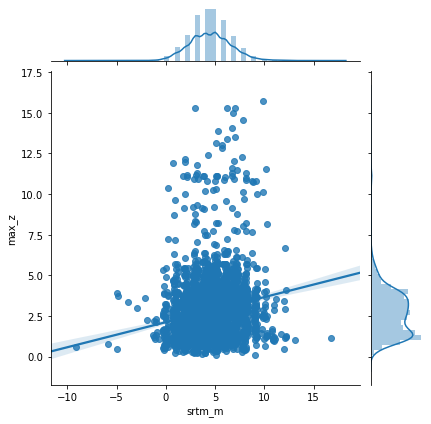

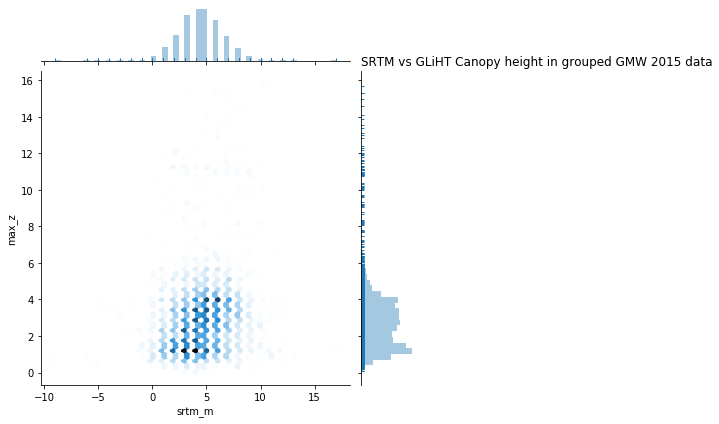

In [52]:
linear_regress(groupedSRTM_gliht_gmw2015, 'srtm_m', 'max_z', True)
linear_regress(groupedSRTM_gliht_gmw2015, 'srtm_m', 'max_z', False) # define intercept as 0
# Scatter plot with dither, regression, and kernel density fits
sns.jointplot(x="srtm_m", y="max_z", data=groupedSRTM_gliht_gmw2015, kind="reg", x_jitter=.3)
# Hex bin plot with regression and histograms
sns.jointplot(x=groupedSRTM_gliht_gmw2015['srtm_m'], y=groupedSRTM_gliht_gmw2015['max_z'], 
              kind='hex', height=6,
              marginal_kws=dict(rug=True))
plt.title('SRTM vs GLiHT Canopy height in grouped GMW 2015 data', loc='left')

##  TNC Landsat Mangroves (tnclandsat) -- Compare GLiHT to SRTM


In [53]:
# Subset to include on CHM height > 0 and GMW2015 > 0
pts_gt0_tnclandsat= pts_all[(pts_all['z_m'] > 0) & (pts_all['tnclandsat'] > 0)]
pts_gt0_tnclandsat

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gliht_ptid,gmf,wam,gmw2015,tnclandsat,geometry
378639,0.56,790135.5,2785233.5,0,21901403,NaN,15031001,378640,NaN,NaN,NaN,1.0,POINT (-78.12195 25.15521)
381211,4.61,790136.5,2785222.5,0,21908604,NaN,15038202,381212,NaN,NaN,NaN,1.0,POINT (-78.12194 25.15511)
381457,3.95,790136.5,2785221.5,0,21908604,NaN,15038202,381458,NaN,NaN,NaN,1.0,POINT (-78.12195 25.15510)
392775,0.94,790528.5,2785177.5,1,21915819,NaN,15045418,392776,NaN,NaN,NaN,1.0,POINT (-78.11807 25.15463)
395499,0.33,790509.5,2785164.5,0,21923019,NaN,15059818,395500,NaN,NaN,NaN,1.0,POINT (-78.11826 25.15452)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58091128,0.40,802808.5,2691685.5,0,43843229,NaN,44123446,58087856,NaN,NaN,NaN,1.0,POINT (-78.01658 24.30900)
58091133,1.07,802813.5,2691685.5,0,43843229,NaN,44123446,58087861,NaN,NaN,NaN,1.0,POINT (-78.01654 24.30900)
58091134,0.55,802814.5,2691685.5,0,43843230,NaN,44123446,58087862,NaN,NaN,NaN,1.0,POINT (-78.01653 24.30900)
58091137,0.28,802817.5,2691685.5,0,43843230,NaN,44123446,58087865,NaN,NaN,NaN,1.0,POINT (-78.01650 24.30900)


### TNC Landsat vs SRTM - all data points

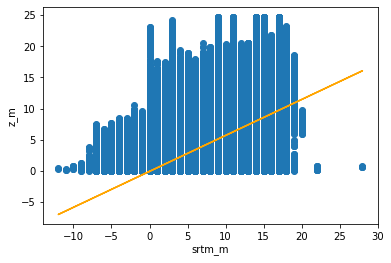

R squared: 0.23773387580562988
intercept: [-0.08235039]
slope: [[0.57689973]]
RMSE: 3.9072959187227396


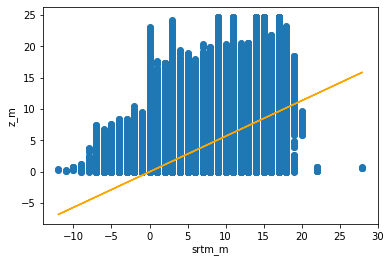

R squared: 0.23764595584967418
intercept: 0.0
slope: [[0.56735388]]
RMSE: 3.907521246445605


Text(0.0, 1, 'SRTM vs GLiHT Canopy height in TNC Landsat polygons')

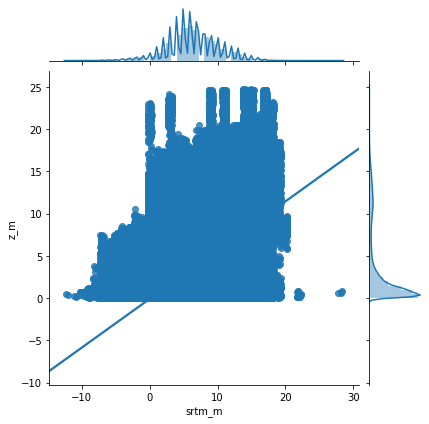

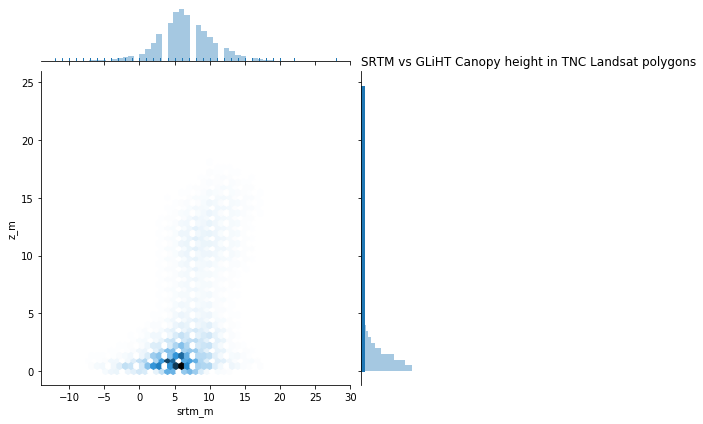

In [54]:
linear_regress(pts_gt0_tnclandsat, 'srtm_m', 'z_m', True)
linear_regress(pts_gt0_tnclandsat, 'srtm_m', 'z_m', False) # define intercept as 0
# Scatter plot with dither, regression, and kernel density fits
sns.jointplot(x="srtm_m", y="z_m", data=pts_gt0_tnclandsat, kind="reg", x_jitter=.3)
# Hex bin plot with regression and histograms
sns.jointplot(x=pts_gt0_tnclandsat['srtm_m'], y=pts_gt0_tnclandsat['z_m'], 
              kind='hex', height=6,
              marginal_kws=dict(rug=True))
plt.title('SRTM vs GLiHT Canopy height in TNC Landsat polygons', loc='left')

### TNC Landsat vs SRTM -- grouped by SRTM ID and height

In [55]:
# Multiple stats on a single column (could be many columns) --> renamed
# Makes the grouped columns into multi-column index
groupedSRTM_gliht_tnclandsat = pts_gt0_tnclandsat.groupby(
    ['srtm_id','srtm_m']
).agg(
    max_z = ('z_m', 'max'),
    min_z = ('z_m', 'min'),
    mean_z = ('z_m', 'mean'),
    median_z = ('z_m', 'median'),
    var_z = ('z_m', 'var'),
    skew_z = ('z_m', 'skew'),
    count_z = ('z_m', 'count'),
) 
groupedSRTM_gliht_tnclandsat.reset_index(inplace=True)  # Reset index to make grouped columns into regular columns
groupedSRTM_gliht_tnclandsat

,srtm_id,srtm_m,max_z,min_z,mean_z,median_z,var_z,skew_z,count_z
0,21901403,0,0.56,0.56,0.560000,0.56,NaN,NaN,1
1,21908604,0,4.61,3.95,4.280000,4.28,0.217800,NaN,2
2,21915819,1,0.94,0.94,0.940000,0.94,NaN,NaN,1
3,21923018,1,0.70,0.35,0.556667,0.62,0.033633,-1.368698,3
4,21923019,0,0.39,0.33,0.360000,0.36,0.001800,NaN,2
...,...,...,...,...,...,...,...,...,...
29733,43843228,0,1.11,0.36,0.715000,0.68,0.075270,0.297013,6
29734,43843229,0,1.07,0.33,0.550000,0.40,0.086433,1.351902,7
29735,43843230,0,1.24,0.08,0.590000,0.53,0.174160,0.561338,6
29736,43843231,0,0.19,0.19,0.190000,0.19,NaN,NaN,1


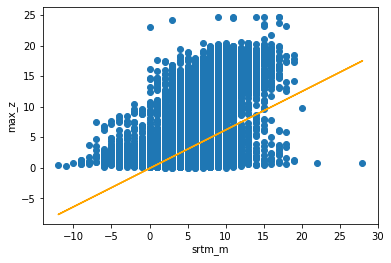

R squared: 0.22618223242272184
intercept: [-0.10875392]
slope: [[0.62939716]]
RMSE: 3.5503084319070664


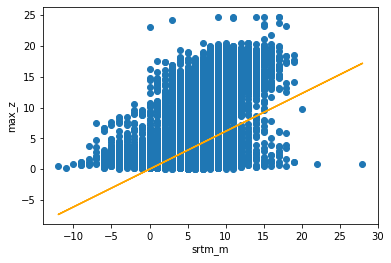

R squared: 0.22598277013004442
intercept: 0.0
slope: [[0.61347934]]
RMSE: 3.5507659731144674


Text(0.0, 1, 'SRTM vs GLiHT Canopy height in grouped TNC Landsat data')

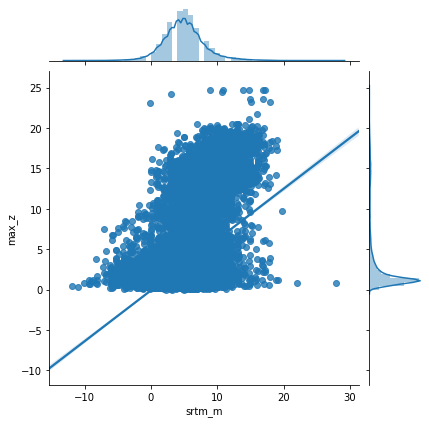

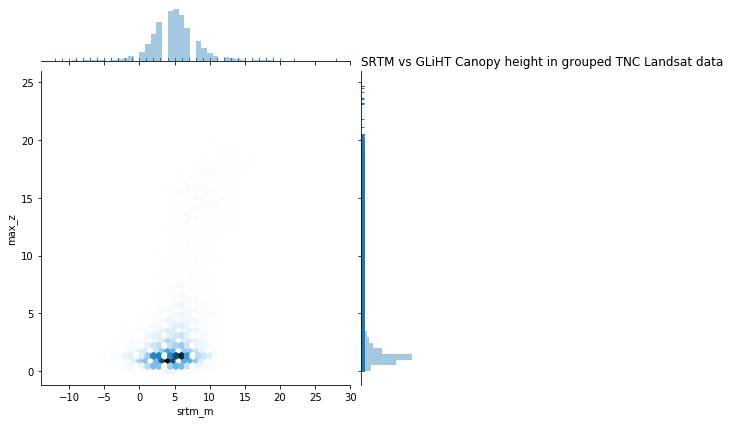

In [56]:
linear_regress(groupedSRTM_gliht_tnclandsat, 'srtm_m', 'max_z', True)
linear_regress(groupedSRTM_gliht_tnclandsat, 'srtm_m', 'max_z', False) # define intercept as 0
# Scatter plot with dither, regression, and kernel density fits
sns.jointplot(x="srtm_m", y="max_z", data=groupedSRTM_gliht_tnclandsat, kind="reg", x_jitter=.3)
# Hex bin plot with regression and histograms
sns.jointplot(x=groupedSRTM_gliht_tnclandsat['srtm_m'], y=groupedSRTM_gliht_tnclandsat['max_z'], 
              kind='hex', height=6,
              marginal_kws=dict(rug=True))
plt.title('SRTM vs GLiHT Canopy height in grouped TNC Landsat data', loc='left')

In [57]:
sns.set(style="white")

In [58]:
# Compare Hex Plots for different mangrove data sources (grouped)
def hexjointplot(df, sourcetext):
    # Hex bin plot with regression and histograms
    sns.jointplot(x=df['srtm_m'], y=df['max_z'],
                  kind='hex', height=10,
                  xlim=(-5, 25), ylim=(0, 20), 
                  marginal_kws=dict(rug=True)
                  )
    title = 'SRTM vs GLiHT Canopy height in {} data'.format(sourcetext)
    plt.title(title, loc='right')
#     plt.xlim(-5,25)
#     plt.ylim(0,25)

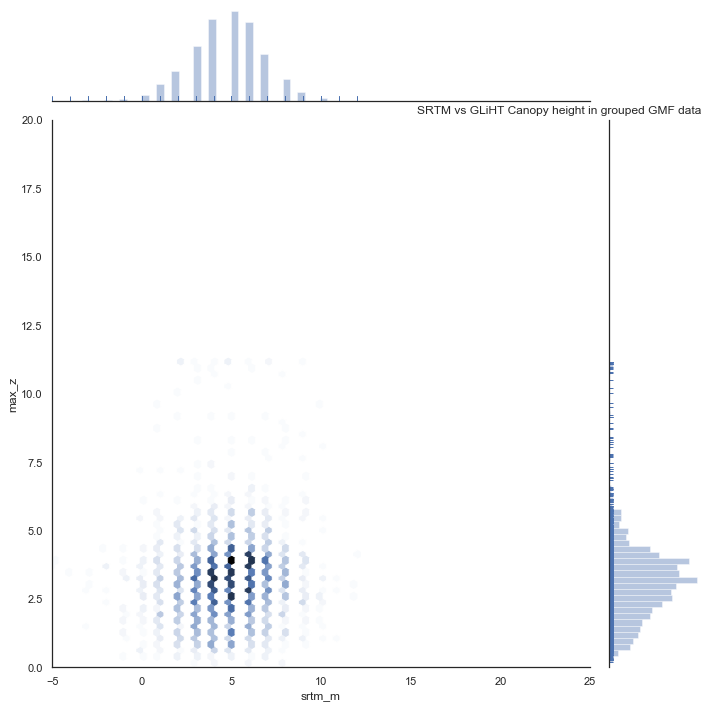

In [59]:
hexjointplot(groupedSRTM_gliht_gmf, 'grouped GMF')

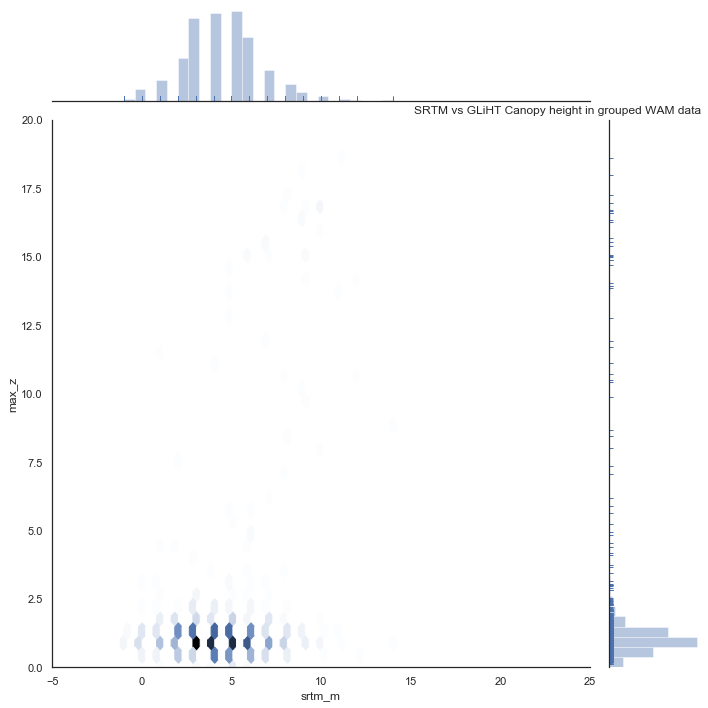

In [60]:
hexjointplot(groupedSRTM_gliht_wam, 'grouped WAM')

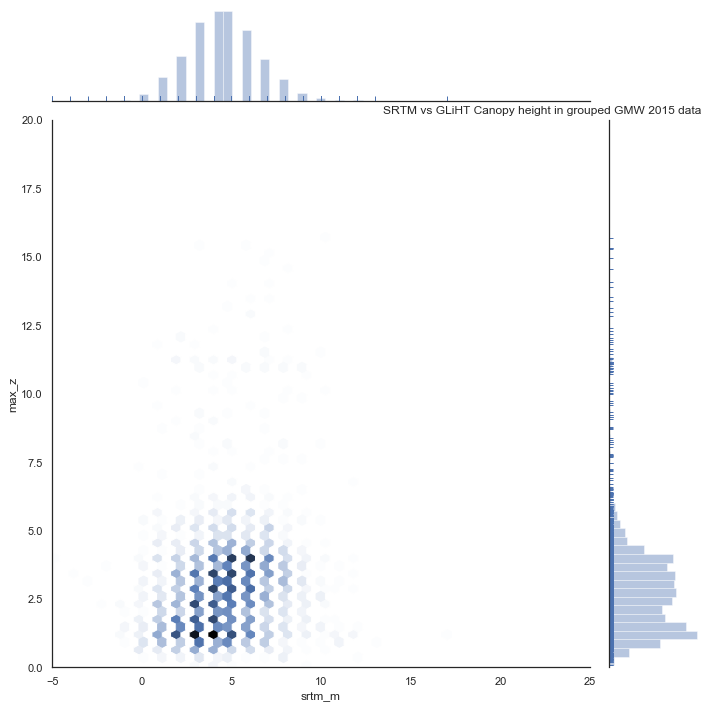

In [61]:
hexjointplot(groupedSRTM_gliht_gmw2015, 'grouped GMW 2015')

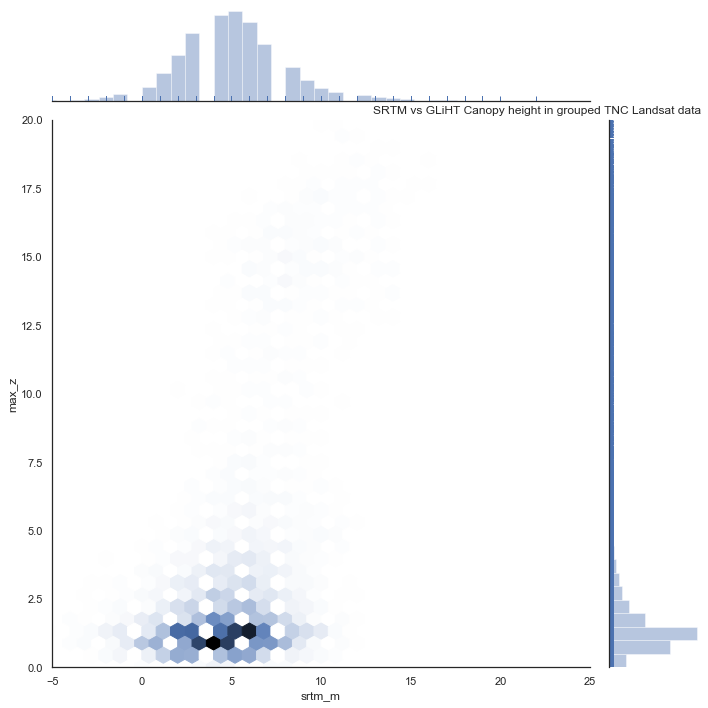

In [62]:
hexjointplot(groupedSRTM_gliht_tnclandsat, 'grouped TNC Landsat')

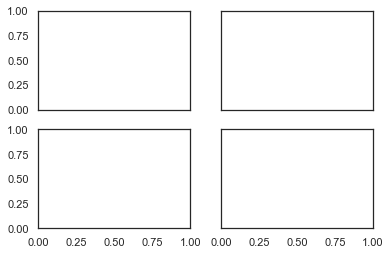

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row')

In [64]:
type(fig)

matplotlib.figure.Figure

In [65]:
type(axes)

numpy.ndarray

In [66]:
axes[0,1]

In [67]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

Text(0.0, 1, 'SRTM vs GLiHT Canopy height in grouped GMW 2015 data')

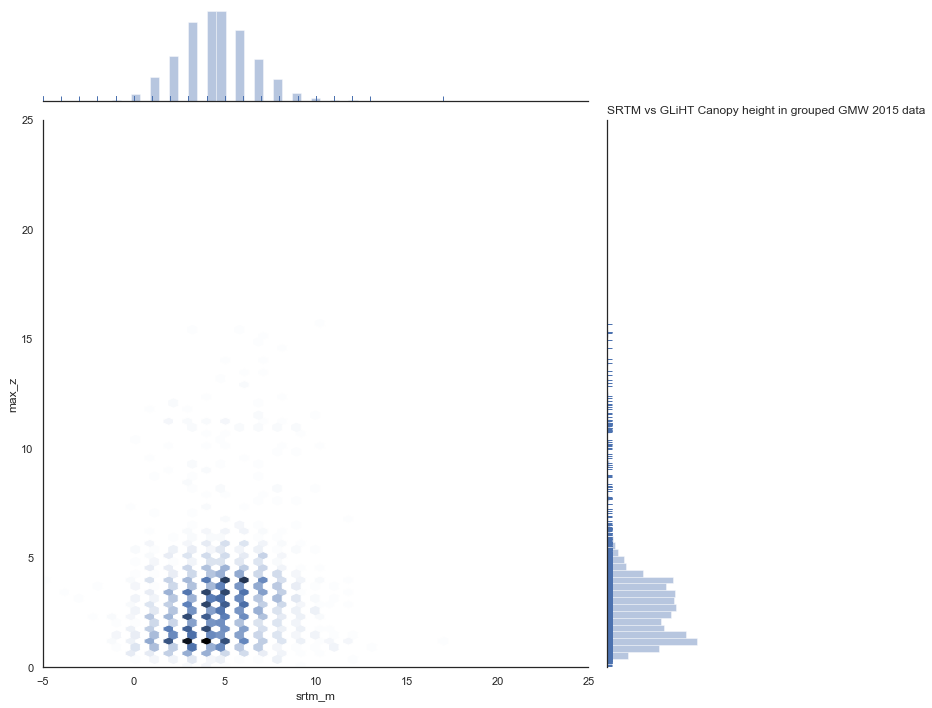

In [68]:
sns.jointplot(x=groupedSRTM_gliht_gmw2015['srtm_m'], y=groupedSRTM_gliht_gmw2015['max_z'], 
              kind='hex', height=10,
              xlim=(-5, 25), ylim=(0, 25), 
              marginal_kws=dict(rug=True))
plt.title('SRTM vs GLiHT Canopy height in grouped GMW 2015 data', loc='left')